## Load Stuff

In [1]:
import torch
from mario_gpt import MarioDataset, MarioLM, SampleOutput
from mario_gpt.utils import view_level, convert_level_to_png, join_list_of_list, characterize

### Load Model

In [2]:
path = '/Users/james/playground/mario-gpt/notebooks/Mario-GPT2-700-context-length/iteration_13459/'
tokenizer_path = '/Users/james/playground/mario-gpt/notebooks/Mario-GPT2-700-context-length-tokenizer/'
mario_lm = MarioLM(lm_path=path, tokenizer_path=tokenizer_path)

Using /Users/james/playground/mario-gpt/notebooks/Mario-GPT2-700-context-length/iteration_13459/ lm


/Users/james/Envs/research3.11/lib/python3.11/site-packages/transformers/models/auto/modeling_auto.py:1509: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Using /Users/james/playground/mario-gpt/notebooks/Mario-GPT2-700-context-length-tokenizer/ tokenizer


In [121]:
from transformers import GPT2LMHeadModel
from optimum.exporters.onnx import export, main_export
from optimum.exporters.onnx.model_configs import GPT2OnnxConfig
from optimum.utils import DummyTextInputGenerator, DummyPastKeyValuesGenerator, DummyInputGenerator, NormalizedTextConfig
from pathlib import Path
from collections import OrderedDict

class DummyHiddenStateGenerator(DummyInputGenerator):
    """
    Generates dummy encoder hidden state.
    """

    SUPPORTED_INPUT_NAMES = (
        "encoder_hidden_states",
    )

    def __init__(
        self,
        task: str,
        normalized_config: NormalizedTextConfig,
        **kwargs,
    ):
        self.batch_size = 1
        self.encoding_size = 768

    def generate(self, input_name: str, framework: str = "pt", int_dtype: str = "int64", float_dtype: str = "fp32"):
        min_value = 0
        max_value = 2
        shape = [self.batch_size, 1, self.encoding_size]
        return self.random_int_tensor(shape, max_value, min_value=min_value, framework=framework, dtype=float_dtype)

class CustomGPT2OnnxConfig(GPT2OnnxConfig):
    def __init__(self, model, task="text-generation"):
        super().__init__(config=model.config, task=task)
        self.DUMMY_INPUT_GENERATOR_CLASSES = (DummyTextInputGenerator, DummyPastKeyValuesGenerator, DummyHiddenStateGenerator)

    @property
    def inputs(self) -> Dict[str, Dict[int, str]]:
        common_inputs = super().inputs
        common_inputs["encoder_hidden_states"] = {0: "batch_size", 1: "sequence_length"}

        return common_inputs

# Create the custom ONNX configuration
custom_config = CustomGPT2OnnxConfig(mario_lm.lm)
model = mario_lm.lm

print("OG Model Configuration:")
print(model.config)

onnx_model_path = Path("/Users/james/playground/mario-gpt/notebooks/custom_onnx_output/")  # Specify your ONNX model path
print(onnx_model_path)
#export(
#    model=model,
#    config=custom_config,
#    output=onnx_model_path,
#    opset=13  # Specify the opset version if different
#)
main_export(
    model_name_or_path="/Users/james/playground/mario-gpt/notebooks/Mario-GPT2-700-context-length/iteration_13459",
    output=onnx_model_path,
    task="text-generation",
    custom_onnx_configs = {"model": custom_config},
    opset=13  # Specify the opset version if different
)


Framework not specified. Using pt to export to ONNX.


OG Model Configuration:
GPT2Config {
  "_name_or_path": "/Users/james/playground/mario-gpt/notebooks/Mario-GPT2-700-context-length/iteration_13459/",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "pad_token_id": 0,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-genera

The task `text-generation` was manually specified, and past key values will not be reused in the decoding. if needed, please pass `--task text-generation-with-past` to export using the past key values.
Using the export variant default. Available variants are:
    - default: The default ONNX variant.
Using framework PyTorch: 2.1.0
Overriding 2 configuration item(s)
	- use_cache -> False
	- pad_token_id -> 0
/Users/james/Envs/research3.11/lib/python3.11/site-packages/transformers/models/gpt2/modeling_gpt2.py:801: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if batch_size <= 0:
Post-processing the exported models...
Deduplicating shared (tied) weights...
Found different candidate ONNX initializers (likely duplicate) for the tied weights:
	lm_head.weight: {'onnx::MatMul_3

In [125]:
prompt = "high elevation, many pipes, some enemies"
mario_lm.prompter.feature_extraction(prompt, return_tensors="pt")[0].shape

torch.Size([10, 768])

In [120]:
context_len = 700-28
with torch.no_grad():   
    seed = mario_lm.generate_seed(1, batch_size=1)
    # No prompt
    encoder_hidden_states = torch.stack(
        [
            mario_lm.prompter(sample_prompt=True)[1]
            for _ in range(seed.shape[0])
        ]
    )
    print(encoder_hidden_states.shape, encoder_hidden_states.dtype)
    out_tensor = seed
    num_steps = 4
    for i in range(num_steps):
        #print(seed)
        inp = out_tensor * 1
        if len(out_tensor.shape) > 0 and out_tensor.shape[-1] > context_len:
            diff = inp.shape[-1] % 14  # height of mario level
            ctx = context_len + diff
            inp = inp[:, -ctx:] * 1
        attention_mask = torch.ones_like(inp).to(inp.device)
        out = mario_lm.lm(
            input_ids=inp,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            token_type_ids=None,
        )
        logits = out.logits.detach()
        if len(logits.shape) == 2:
            logits = logits.view(1, 1, -1)
        next = logits[:, -1, :].argmax(-1)
        out_tensor = torch.cat(
            [out_tensor, next.unsqueeze(-1)], dim=-1
        )
    #print(out_tensor)
    sample_out = SampleOutput.from_level_predictions(
        out_tensor,
        out_tensor[:, -num_steps:],
        mario_lm.tokenizer,
        mario_lm.prompter,
    )

    #print(sample_out.level)
    

torch.Size([1, 1, 768]) torch.float32
Failed to generate string or image representation for full level! Got error tuple index out of range
Failed to generate string or image representation for sampled predictions! Got error tuple index out of range


### Load Dataset

In [73]:
dataset = MarioDataset(mario_lm.tokenizer)
mario_lm.tokenizer = dataset.tokenizer

Token indices sequence length is longer than the specified maximum sequence length for this model (102116 > 1024). Running this sequence through the model will result in indexing errors


No level string specified, using default string FULL_LEVEL_STR_WITH_PATHS...





In [74]:
view_level(dataset.input_ids[:700], mario_lm.tokenizer)

['--------------------------------------------------',
 '--------------------------------------------------',
 '--------------------------------------------------',
 '--------------------------------------------------',
 '-------------------------------------------------o',
 '--------XSSSSS---------------------------------SSS',
 '--------X-----------------------------------------',
 '--------X-----------------------------------------',
 '-------EX--E-X---------------xxxx-?-----------xxxx',
 '--------XSS?SX---QQ?QQ------xx<>-x-----------xx--?',
 '---------------------------xx-[]--x---------xx----',
 '--------------------------xx--[]---x-------xx-----',
 'xxxxxxxxxxxxxxxxxxxxxxxxxxx---[]----xxxxxxxx------',
 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---XXX']

#### View string representation of level

In [4]:
view_level(dataset.input_ids[:700], mario_lm.tokenizer)

['--------------------------------------------------Y',
 '--------------------------------------------------Y',
 '--------------------------------------------------Y',
 '--------------------------------------------------Y',
 '-------------------------------------------------oY',
 '--------XSSSSS---------------------------------SSSY',
 '--------X-----------------------------------------Y',
 '--------X-----------------------------------------Y',
 '-------EX--E-X---------------xxxx-?-----------xxxxY',
 '--------XSS?SX---QQ?QQ------xx<>-x-----------xx--?Y',
 '---------------------------xx-[]--x---------xx----Y',
 '--------------------------xx--[]---x-------xx-----Y',
 'xxxxxxxxxxxxxxxxxxxxxxxxxxx---[]----xxxxxxxx------Y',
 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---XXXX']

#### Image

##### Previewing the first 50 columns of the dataset

/home/kokkgoblin/miniconda3/envs/py39/lib/python3.9/site-packages/Pillow-9.1.1-py3.9-linux-x86_64.egg/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


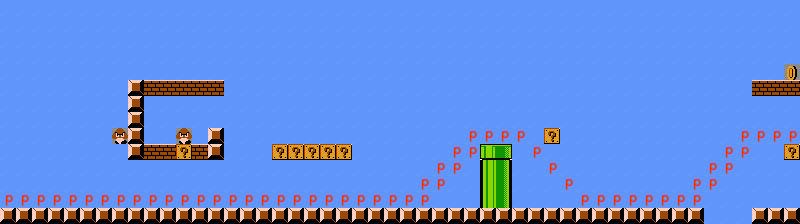

In [5]:
img = convert_level_to_png(dataset.input_ids[:700],  mario_lm.tokenizer)[0]
img

#### Set device

In [6]:
device = torch.device('cuda')
mario_lm = mario_lm.to(device)

## Generating Levels

In [3]:
prompts = ["many pipes, many enemies, some blocks, high elevation"]

In [33]:
generated_level = mario_lm.sample(
    prompts=prompts,
    num_steps=420,
    temperature=2.0,
    use_tqdm=True,
    use_argmax=False
)

shape: torch.Size([1, 672]), torch.Size([1, 701]) first: 56, last: 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [01:15<00:00,  9.25it/s]


In [34]:
generated_level.level

['--------------------------------------------------',
 '--------------------------------------------------',
 '------------------------------xxx-----------------',
 'SS---------------------------xx--x----------------',
 '--------X-------------------xQQ---x----------E----',
 '---------------------------xx------x--------------',
 '--------------------------xx--------x-xxxx--------',
 '-------------------------xx----------xx---xo------',
 'XXXXX------XS----------xxx----------XXX----x------',
 'xxxxx----------X------xx-X---------XXXX-----x-----',
 'xE-X-x--------XX-----xx--X----------XXX------x---x',
 '<>-X--x----SSSXX----xx---X---------------SSSS-x-xx',
 '[]-X--Sxxxxxxxxxxxxxx--------------------------xx-',
 'XXXXXXXXXXXXXXXXXXXXX-------------------------XXXX']

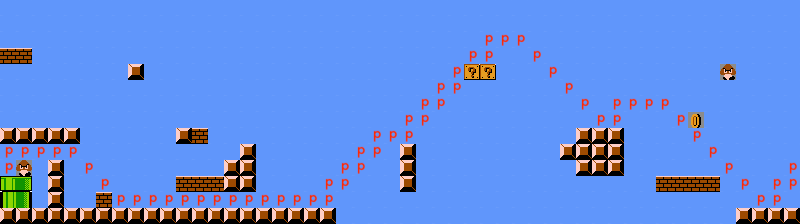

In [35]:
generated_level.img

#### Check if the model generated the correct level
##### Because of the stochastic nature of the model and the small training dataset, the model may generate levels that do not completely match the given prompt

In [19]:
generated_level.prompt

'some pipes, many enemies, some blocks, high elevation'

## Play Levels Interactively

In [20]:
generated_level.play()

Playing level interactively -- /tmp/tmpnveevydo.txt!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Run Astar Agent

In [26]:
generated_level.run_astar()

Running Astar agent on level! -- /tmp/tmpw0ril9xa.txt
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Continue generation

### You can also continue generation, making giant levels

In [34]:
# different prompt
prompts = ["no pipes, some enemies, some blocks, high elevation"]

In [38]:
generated_level_continued = mario_lm.sample(
    seed=generated_level,
    prompts=prompts,
    num_steps=1400,
    temperature=2.0,
    use_tqdm=True
)

shape: torch.Size([1, 685]), torch.Size([1, 2800]) first: 56, last: 13: 100%|█████| 1400/1400 [00:30<00:00, 45.35it/s]
/home/kokkgoblin/miniconda3/envs/py39/lib/python3.9/site-packages/Pillow-9.1.1-py3.9-linux-x86_64.egg/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


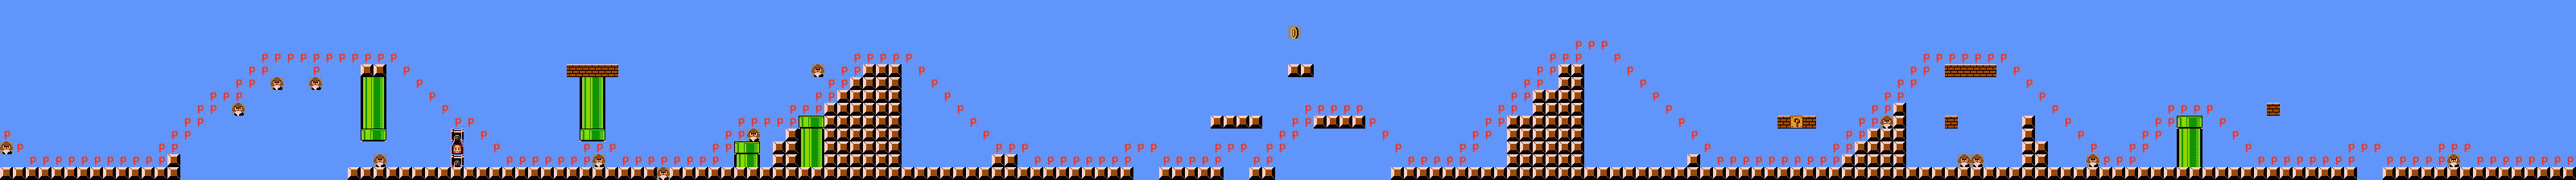

In [39]:
generated_level_continued.img

In [42]:
generated_level_continued.run_astar()

Running Astar agent on level! -- /tmp/tmpdaalo9xl.txt
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Batch multiple prompts

In [72]:
prompts = ["no pipes, many enemies, some blocks, high elevation", "many pipes, no enemies, many blocks, high elevation", "many pipes, many enemies, little blocks, low elevation"]

generated_levels = mario_lm.sample(
    prompts=prompts,
    num_steps=1400,
    temperature=2.0,
    use_tqdm=True
)

shape: torch.Size([3, 672]), torch.Size([3, 1401]) first: 56, last: 13: 100%|█████| 1400/1400 [01:01<00:00, 22.84it/s]


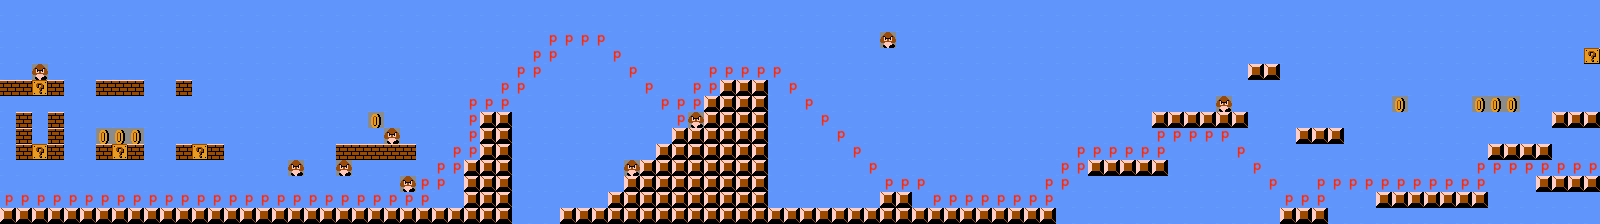

In [73]:
generated_levels[0].img

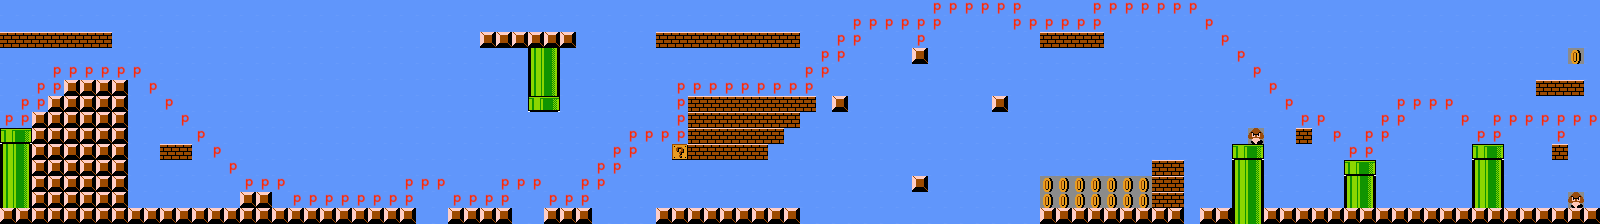

In [74]:
generated_levels[1].img

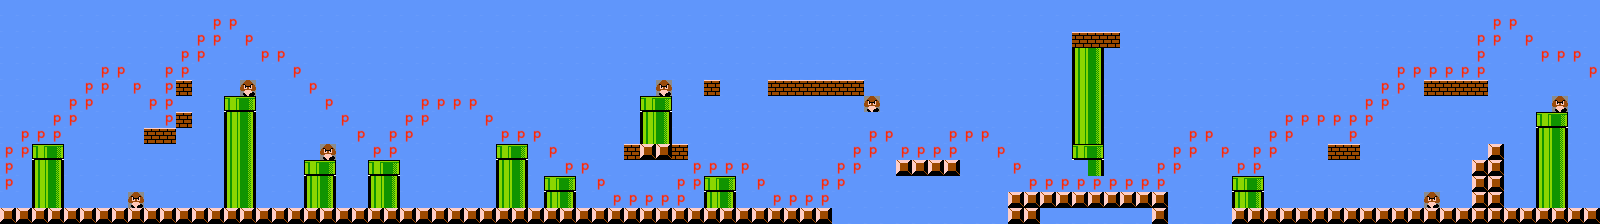

In [75]:
generated_levels[2].img

### Generate Timelapses

In [76]:
from mario_gpt.utils import generate_timelapse

In [79]:
timelapse_0 = generate_timelapse(generated_levels[0].level_tensor, mario_lm)

In [80]:
timelapse_1 = generate_timelapse(generated_levels[1].level_tensor, mario_lm)

In [81]:
timelapse_2 = generate_timelapse(generated_levels[2].level_tensor, mario_lm)

In [82]:
# save
# import imageio
# imageio.mimsave('timelapse_0.gif',timelapse_0,fps=60)